Reinforcement Learning Exam

- Year: 2024-2025
- Instructor: Richard Combes
- Email: richard.combes@centralesupelec.fr
- Deadline: 28th febuary at 23h59 (Paris time)


Instructions:
- the exam is to be done by groups of 2 students
- complete this notebook with your answers
- your answers will include both the python code as well as figures and explanations in text
- when you are done, send this notebook by email to the instructor
- to avoid confusion use the following naming convention for your notebook file: "(name of first student)(name of second student).ipynb"
- any exam received after the deadline will not be considered

Introduction and Model

The goal of this exam is to learn how to drive a car up a hill using reinforcement learning. To do so we will consider the following model.

We assume that the car is modelled by a point, located at location $(x,z)$ where $x$ and $z$ denote the coordinates of the car on the $x$ axis and the $z$ axis respectively. The car is located on a hill, so that $z = h(x)$ where $h(x)$ denotes the height of the hill at location $x$ given by
$$
h(x) = {1 \over 2} x^2
$$

Location $(x,z) = (0,0)$ is the bottom of the hill, and location $x=(1,{1 \over 2})$ is the top of the hill. 

The goal is for the driver of the car to get the car to the top of the hill as fast as possible, and we assume that once the top of the hill has been reached the experiment stops. An illustration is found below, where the car is represented as a red dot and the target is represented as a green dot.

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import os
import random as rd
import itertools as iter

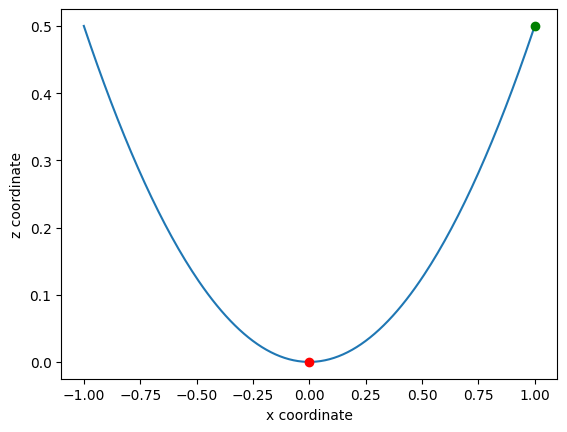

In [15]:
deltax = 0.01
x_vector = np.arange(-1,1+deltax,deltax)
z_vector = 0.5*(x_vector) ** 2
x_0 = 0
z_0 = 0
plt.figure()
plt.plot(x_vector, z_vector)
plt.plot(x_0, z_0,'ro')
plt.plot(1, 0.5,'go')
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.show()

Control Strategy

To control the car, the driver acts on the engine and its action is modelled by $w \in \{-1,0,1\}$ where $w=0$ means that the engine is inactive, $w=1$ means that the driver is accelerating the car forward as hard as possible, and $w=-1$ means that the driver is accelerating the car backwards as hard as possible.

The trajectory of the car is determined by Newton's law which is the second order differential equation:
$$
    m {d^2  x \over d t^2}(t) =  {1 \over \sqrt{1 + (h'(x(t)))^2}} \Big[ -g m {h'(x(t)) \over \sqrt{1 + (h'(x(t)))^2}} + K m w(t)\Big]
$$
with $x(t)$ the location of the car at time $t$, $w(t)$ the action of the driver at time $t$, $m$ the mass of the car, $g$ the gravitational constant and $K$ proportional to the maximal torque of the engine.

We assume that the car starts at the bottom of the hill from a dead stop, so that 
$$
\Big(x(0),{d  x \over d t}(0)\Big)  = (0,0)
$$

The differential equation simplifies to:
$$
    {d^2  x \over d t^2}(t) =  - {g x(t) \over 1 + x(t)^2} +  {K w(t) \over \sqrt{1 + x(t)^2}}
$$
and we assume that $g=10$ and $K=1$ throughout.




Casting the problem as a Markov Decision Process

In order to fit the framework seen in class, we consider a discretized time version that can be written as a Markov Decision Process. The state of the system at time instants $k=0,1,...$ is given by its position and speed at time instants $t = k \Delta$ for $k$ integer:
$$
s_k = \Big(s_{k,0},s_{k,1}\Big) = \Big( x(k \Delta) , {d x \over d t}(k \Delta) \Big)
$$
where $\Delta$ is a small discretization step. It is noted that the state contains both the position and the speed of the car, which is necessary.

The action at time instant $k$ is given by
$$
a_k = w(k \Delta t) \in \{-1,0,+1\}   
$$
The reward is given by
$$
r_k = 1( |s_{k,0}| \ge 1 )
$$
so that the reward is $1$ if the top of the hill has been reached and $0$ otherwise.

One can readily check that this defines a Markov Decision Process. 

The evolution of the state $s$ given the action $a$ is given by discretizing the differential equation above:
$$
    {s_{k+1,0} - s_{k,0} \over \Delta} =  s_{k,1} \text{     and       } {s_{k+1,1}-s_{k,1} \over \Delta}   =  { g s_{k,0} \over 1 + (s_{k,0})^2 }  +  {K a_k \over \sqrt{1 + (s_{k,0})^2} }
$$

We will consider $\Delta = 0.01$ throughout.

Getting Started

In order to get started you are provided with several pieces of code:
- the "next_state" subroutine takes as input the current state $s_k$ and the current action $a_k$ and outputs the next state $s_{k+1}$
- the "policy1" subroutine is an example of a policy. We recall that a policy takes the current state $s_k$ as an input and outputs the current action $a_k$. Here this policy is a simple policy where $a_k=1$ irrespective of $s_k$, meaning that the driver always accelerates the car forward.
- the "generate_episode" subroutine takes as an input a time horizon $T$ and a policy, and outputs the trajectory of the system $(s_{k})_{k=1,...,T}$.
- the last piece of code generates an animation that represents the trajectory of the system under the policy described above

You can reuse and modify those pieces of code in order to answer the exam questions.

Note: some policies might take a large, possibly infinite, amount of time in order to reach the top of the hill, therefore you should simulate episodes up to a well chosen maximal duration $T_{max}$, in order to avoid infinite loops.


In [16]:
def next_state(s,a):
    delta = 0.01
    g = 10.0
    K = 1.0
    snext = list(s)
    snext[0] = s[0] + s[1]*delta
    snext[1] = s[1] + (-g*s[0]/(1 + (s[0])**2) + K*a/np.sqrt(1 + (s[0])**2))*delta
    return snext

In [17]:
def policy1(s):
    a = 1
    return a

In [18]:
def generate_episode(T,policy,next_state=next_state):
    s_t = []
    s = [0.0,0.0]
    for t in range(T):
        s_t.append(list(s))
        a = policy(s)
        s = next_state(s,a)
    return s_t

In [19]:
"""%matplotlib notebook


T = 1000
s_t = generate_episode(T,policy1)
fig, ax = plt.subplots()
line, = plt.plot(-1, 1,'ro')
line1, = plt.plot(1, 0.5,'go')
line2, = plt.plot(x_vector, z_vector,'b')
ax.set_xlim(-1.1,1.1)
ax.set_ylim(0, 0.6)
def animate(t):
    s = s_t[t]
    line.set_data((s[0],0.5*s[0]**2))
    return line
anim = FuncAnimation(fig, animate, frames=(T-1), interval=1000)
plt.show()"""

"%matplotlib notebook\n\n\nT = 1000\ns_t = generate_episode(T,policy1)\nfig, ax = plt.subplots()\nline, = plt.plot(-1, 1,'ro')\nline1, = plt.plot(1, 0.5,'go')\nline2, = plt.plot(x_vector, z_vector,'b')\nax.set_xlim(-1.1,1.1)\nax.set_ylim(0, 0.6)\ndef animate(t):\n    s = s_t[t]\n    line.set_data((s[0],0.5*s[0]**2))\n    return line\nanim = FuncAnimation(fig, animate, frames=(T-1), interval=1000)\nplt.show()"

In [20]:
import os

def get_next_gif_path(folder: str, base_name: str = "animation") -> str:
    """
    Determines the next available file path for a new GIF in the given folder.
    
    :param folder: The directory containing the GIF files.
    :param base_name: The base name for the GIF files (default is "animation").
    :return: The next available file path as a string.
    """
    existing_numbers = []
    
    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # List files in the directory
    for file in os.listdir(folder):
        if file.startswith(base_name) and file.endswith(".gif"):
            try:
                number = int(file[len(base_name) + 1:-4])  # Extract the number
                existing_numbers.append(number)
            except ValueError:
                continue
    
    next_number = max(existing_numbers, default=0) + 1
    return os.path.join(folder, f"{base_name}_{next_number}.gif")

# Example usage
folder_path = "./gifs"
new_gif_path = get_next_gif_path(folder_path)
print("Next available GIF path:", new_gif_path)

Next available GIF path: ./gifs\animation_14.gif


In [21]:
def simulate_policy(policy, T=int(1e4), show=False):
    s_t = generate_episode(T, policy)
    if show:
        fig, ax = plt.subplots()
        line, = plt.plot(0, 0, 'ro')
        line1, = plt.plot(1, 0.5, 'go')
        line2, = plt.plot(x_vector, z_vector, 'b')
        ax.set_xlim(-1.1,1.1)
        ax.set_ylim(0, 0.6)

    def animate(t):
        s = s_t[t]
        line.set_data([s[0]], [0.5*s[0]**2])
        return line
    
    success_t = 0
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            success_t = t
            break

    if success_t != 0:
        print(f"The car reached the top of the hill at t={success_t}.")
    else:
        print(f"The car did not reach the top of the hill after t_max={T}.")

    if show:
        gif_path = get_next_gif_path("./gifs")
        if os.path.exists(gif_path):  # Check if the file exists
            os.remove(gif_path)       # Delete the file
            print(f"{gif_path} has been deleted.")
        else:
            print(f"{gif_path} does not exist.")
        anim = FuncAnimation(fig, animate, frames=range(0, T, 10), interval=5000 / (10*T))
        anim.save(gif_path, writer="pillow")
        display(HTML(f'<img src="{gif_path}">'))

        plt.close(fig)

simulate_policy(policy1, T=5000, show=False)

this_gif = "./gifs/animation_9.gif"
display(HTML(f'<img src="{this_gif}">'))

The car reached the top of the hill at t=4793.


___
Question 1. Observe and comment the result of the simple policy described above where $a_k=1$ for all $k$. What is the amount of time required for the car to reach the top of the hill ? Is this policy optimal, and if not, can you suggest a better policy ?

**Answer:** The car reaches the top of the hill after 4793 states. In this policy, the car always accelerates. The problem is that the absolute speed decreases when $s_{k,0} \leq 0$ and $a_k = 1$. A better policy is to take advantage of the states where $s_{k,0} \leq 0$ to set $a_k = -1$ and get even more speed.

So the policy would be:
- $a_k=1$ when $s_{k,1} \geq 0$
- $a_k=-1$ when $s_{k,1} < 0$

___
Question 2. Consider three policies: 
- the policy where $a_k = 1$ when $s_{k,0} \ge 0$, and $a_k = -1$ when $s_{k,0} < 0$ 
- the policy where $a_k$ is i.i.d. uniformly distributed in $\{-1,0,1\}$
- the policy where $a_k = 1$ when $s_{k,0} \ge 0$, and $a_k = 0$ when $s_{k,0} < 0$ 

For each of those three policies, simulate the trajectory of the system and comment on the time necessary for the car to reach the top of the hill.


In [22]:
### FIRST POLICY ###
def policy_Q2_1(s):
    a = 1 if s[0] >= 0 else -1
    return a

simulate_policy(policy_Q2_1, show=True)

The car reached the top of the hill at t=5869.
./gifs\animation_14.gif does not exist.


As we can see, with the first policy, the time to reach the top of the hill is 5869, which is longer than the previous simulation. It surprises me. Actually, we notice that the car spends more time on the $s_{k,0}\leq 0$ area so it may take it longer to reach the top, even it it reaches it with more speed.

The car reached the top of the hill at t=5471.
./gifs\animation_15.gif does not exist.


KeyboardInterrupt: 

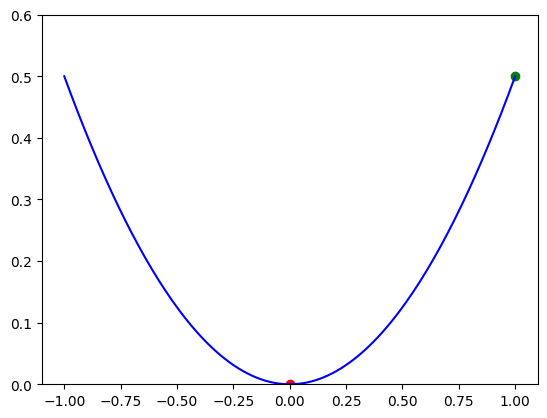

In [23]:
### SECOND POLICY ###
def policy_Q2_2(s):
    a = np.random.choice([-1, 0, 1])
    return a

simulate_policy(policy_Q2_2, show=True)

This policy is clearly not optimal. We observe that the driver takes random decisions and it takes often more time to reach the top, even though for some tries, the car reaches the top faster.

In [ ]:
### THIRD POLICY ###
def policy_Q2_3(s):
    a = 1 if s[0] >= 0 else 0
    return a

simulate_policy(policy_Q2_3, show=True)

The car reached the top of the hill at t=5697.
./gifs\animation_12.gif does not exist.


This policy is better than the first one (of the 2nd question) but worst than the original one (from question 1). One interpretation can be that by shutting down the engine ($a_k=0$), we don't gain as much speed as we could (by for example decelerating only when $s_{k,0}\geq 0$ and $s_{k,1}\leq 0$).

___
Question 3. We would like to compute the optimal policy which gets the car to the top of the hill as quickly as possible. As seen in class, the optimal policy can be found using dynamic programming, by implementing Value Iteration. Do you believe that it is possible in practice to do so for solving the problem at hand ? Justify your answer using precise quantitative arguments.

Value Iteration runs in $O(|\mathcal{A}||\mathcal{S}|^2)$, with $\mathcal{A},\mathcal{S}$ the sets of possible actions and possible states. Althgough the number of possible actions is low, the number of states is very important and roughly proportional to $\frac{1}{\Delta}^2$, rendering Value Iteration impractical for small quantization sizes.

___
Question 4. We now wish to find the best policy amongst a relatively small set of simple policies. We consider the set of policies such that $a_k$ solely depends on the signs of the position $s_{k,0}$ and speed $s_{k,1}$, so that
$$
a_k = f( \text{sign}(s_{k,0}),\text{sign}(s_{k,1}))
$$
where $f: \{-1,1\} \to \{-1,0,1\}$. How many such policies are there ? For each of those policies, simulate the trajectory of the system, find the best one, and provide a physical argument why this policy is indeed the best.


There are only $3^{(2\times 2)} = 81$ possible policies in this policy set. Each policy can be represented as a 4-element vector giving the value of f for each sign configuration of $s_{k,0},s_{k,1}$.

In [24]:

def get_policy(vals):
    '''
    returns the policy function f given an value vector, containing the values of f for input signs [(-1,-1),(-1,1),(1,-1),(1,1)]
    '''
    def f(s):
        s0,s1 = int((np.sign(s[0])+1)/2), int((np.sign(s[1])+1)/2) # interpret the signs as bits
        return vals[2*s0+s1]
    
    return f

policies = iter.product([-1,0,1], repeat=4) # Enumerate all the possible policies

T = 5000
best = [np.nan,np.nan,np.nan,np.nan]
best_score = T+1

for p in policies:
    policy = get_policy(p)
    s_t = generate_episode(T,policy)
    
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            if t<best_score:
                best = p
                best_score = t
            break

print('The best policy is ({}) with duration {} steps'.format(best,best_score))

The best policy is ((-1, 1, -1, 1)) with duration 424 steps


This policy is expected since it accelerates as soon as the speed is positive, and reverses as soon as the speed is negative. Whenever we move backward, we take as much momentum as possible by accelerating backwards, and conversely accelarate forwards as much as we can as soon as we start moving forwards.

___
Question 5. Based on the question above, we now propose to apply policy gradient to the problem. We consider a set of parameterized policies, parameterized by a two dimensional vector $\theta = (\theta_0,\theta_1)$, where the action probabilities are given as
$$
   \mathbb{P}( a_t = 1| s_t) = \phi( \text{sign}(s_{k,0})\theta_0 + \theta_1 \text{sign}(s_{k,1}))
\text{ and } \mathbb{P}( a_t = -1| s_t) = 1-\phi( \text{sign}(s_{k,0})\theta_0 + \theta_1 \text{sign}(s_{k,1}))
$$
where $\phi$ is the sigmoidal function 
$$
\phi(x) = {1 \over  1+e^{-x}}
$$
Compute the policy gradient estimate, and implement policy gradient descent as seen in class. How many iterations are necessary in order to obtain a good policy ?

Note: you should be careful in how the initial value of $\theta$ and the step size $\eta$ are chosen, as those parameters impact the convergence speed and their values should be found by trial and error. 


We start by noting that $\phi(x) = 1-\phi(-x)$. Therefore we can write the policy gradient estimator for an episode $(s_t,a_t,r_t)_t$ as :
$$g = \left(\sum_t\nabla_{\!\theta}\ ln\ \phi(a_t\langle sgn(s_t),\theta\rangle)\right)\left(\sum_t \lambda^tR_t\right)$$

We can then compute the gradient inside the sum to get :
$$g = \left(\sum_t s_t\cdot a_t\cdot e^{-a_t\langle sgn(s_t),\theta\rangle}\cdot ln\ \phi(a_t\langle sgn(s_t),\theta\rangle)\right)\left(\sum_t\lambda^t R_t\right)$$

with $sgn$ denoting the signum function.

After trial and error, we found that an initial state of $(1000,1000)$ and a learning rate $\eta=100$ provided a good convergence rate. With this policy family we get an average 

In [25]:
def sigmoid(x):
    '''return the values of the sigmoid function at inputs x (ndarray)'''
    return 1/(1+np.exp(-x))

def get_policy2(theta):
    '''Returns the policy function for a parameter vector theta'''
    def f(s):
        sign = np.sign(s)
        p = sigmoid(np.dot(sign,theta))
        a = np.random.choice([-1,1],p=[1-p,p])
        return a
    return f

def policy_grad2(theta,s,a):
    '''
    grad = s*a
    grad *= np.exp(-a*np.dot(np.sign(s),theta))
    grad *= 1/(sigmoid(a*np.dot(np.sign(s),theta)))
    '''
    grad = 1-sigmoid(a*np.dot(np.sign(s),theta))
    grad *= np.sign(s)*a
    return grad

def policy_gradient(lamda,I,T,policies,grad,eta,w0):
    '''Runs a policy gradient algorithm
    Inputs :
    - discount factor lamda
    - number of episodes I
    - number of steps for each episode T
    - policy function taking parameter vector as input and returns the associated policy
    - grad function giving the gradient of the log-policy for a given parameterisation, a state vector and the chosen action
    - learning rate eta
    - initial estimate w0'''
    w_i = []
    R_i = []
    w = w0
    policy = policies(w)
    for i in range(I):
        s_t = []
        s = [0.0,0.0]
        R,L = 0.0,[0.0,0.0]
        for t in range(T):
            s_t.append(list(s))
            a = policy(s)
            s = next_state(s,a)
            r = s[0]>1
            R += lamda**t*r
            L -= grad(w,s,a)
            if r:
                break
        w_i.append(w)
        R_i.append(R)
        w += eta*R*L
        policy = policies(w)
    return np.mean(w_i,0),R_i,w_i

w,R_i,w_i = policy_gradient(0.99,1000,1000,get_policy2,policy_grad2,1e2,[-2400.0,3400.0])

C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\2718383421.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\2718383421.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Policy gradient descent output : [-5383.1762791  6383.1762791]
Mean number of steps : 484.6, Success rate 1.0


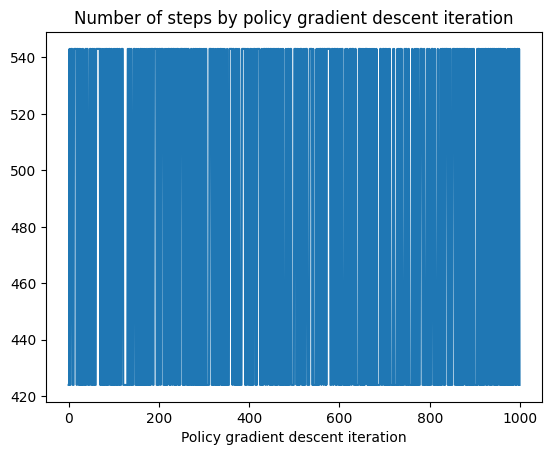

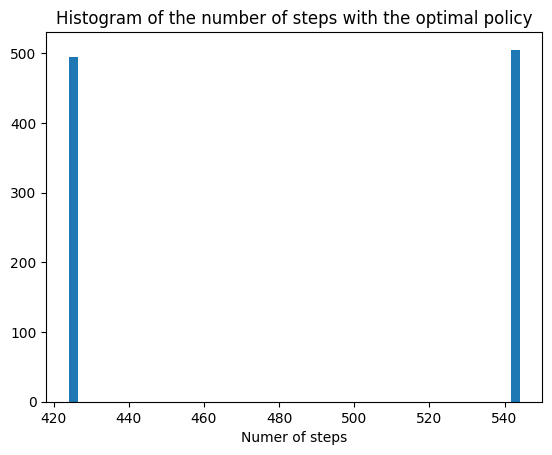

In [26]:
# Get the average number of steps with this policy
N = 1000
T = 1000
steps = T*np.ones(N)
for i in range(N):
    s_t = generate_episode(T,get_policy2(w))
    
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            steps[i] = t
            break

plt.figure()
plt.plot(range(len(R_i)),np.log(R_i)/np.log(0.99))
plt.xlabel('Policy gradient descent iteration')
plt.title('Number of steps by policy gradient descent iteration')

plt.figure()
plt.hist(steps,bins=50)
plt.xlabel('Numer of steps')
plt.title('Histogram of the number of steps with the optimal policy')

print('Policy gradient descent output : {}'.format(w))
print('Mean number of steps : {}, Success rate {}'.format(np.mean(steps[steps<T]),np.sum(steps<T)/N)) 

___
Question 6. We now wish to apply policy gradient to another set of parameterized policies, once again parameterized by a two dimensional vector $\theta = (\theta_0,\theta_1)$ where the action probabilities are given as
$$
   \mathbb{P}( a_t = 1| s_t) = \phi( s^\top \theta)
\text{ and } \mathbb{P}( a_t = -1| s_t) = 1-\phi( s^\top \theta)
$$
where $\phi$ is the sigmoidal function 
$$
\phi(x) = {1 \over  1+e^{-x}}
$$
and
$$
s^\top \theta= s_{k,0} \theta_0 + \theta_1 s_{k,1}
$$
which is the dot product between $s$ and $\theta$ (i.e. the policy is linear).

As in the previous question, compute the policy gradient estimate, and implement policy gradient descent as seen in class. How many iterations are necessary in order to obtain a good policy ?


The computation is very similar to the one from the previous question, which provides us the policy gradient estimator :
$$g = \left(\sum_t s_t\cdot a_t\cdot e^{-a_t\langle s_t,\theta\rangle}\cdot ln\ \phi(a_t\langle s_t,\theta\rangle)\right)\left(\sum_t\lambda^t R_t\right)$$

In [27]:
def get_policy3(theta):
    '''Returns the policy function for a parameter vector theta'''
    def f(s):
        p = sigmoid(np.dot(s,theta))
        a = np.random.choice([-1,1],p=[1-p,p])
        return a
    return f

def policy_grad3(theta,s,a):
    '''
    grad = s*a
    grad *= np.exp(-a*np.dot(np.sign(s),theta))
    grad *= 1/(sigmoid(a*np.dot(np.sign(s),theta)))
    '''
    grad = 1-sigmoid(a*np.dot(s,theta))
    grad *= np.array(s)*a
    return grad

w,R_i,w_i = policy_gradient(0.99,500,1000,get_policy2,policy_grad2,1e2,[500.0,500.0])

C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\2718383421.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\2718383421.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\3930788472.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(R_i)),np.log(R_i)/np.log(0.99))
c:\Users\Admini\CS\Cours\10 - SM10\3-Reinforcement Learning\ExamRL\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Admini\CS\Cours\10 - SM10\3-Reinforcement Learning\ExamRL\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Policy gradient descent output : [501.40512749 499.57067096]
Mean number of steps : nan, Success rate 0.0


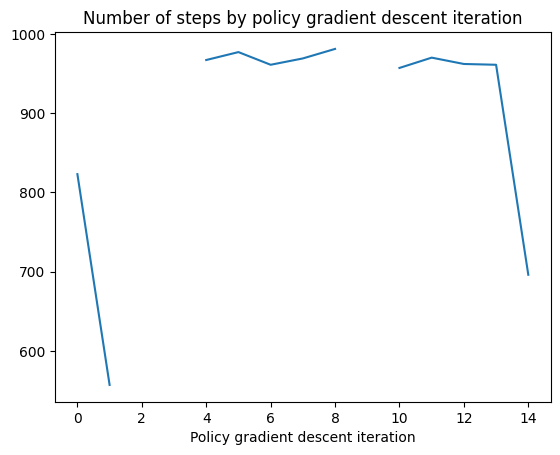

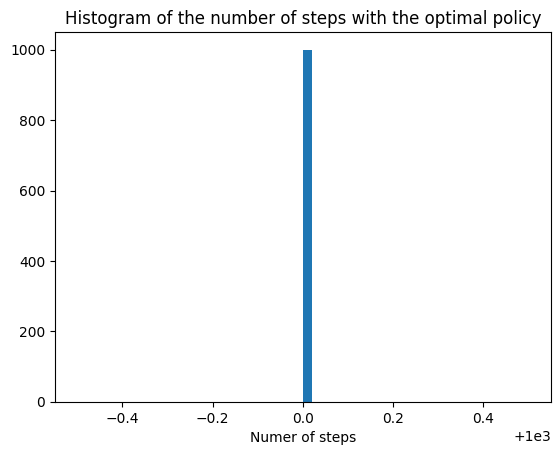

In [28]:
# Get the average number of steps with this policy
N = 1000
T = 1000
steps = T*np.ones(N)
for i in range(N):
    s_t = generate_episode(T,get_policy2(w))
    
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            steps[i] = t
            break

plt.figure()
plt.plot(range(len(R_i)),np.log(R_i)/np.log(0.99))
plt.xlabel('Policy gradient descent iteration')
plt.title('Number of steps by policy gradient descent iteration')

plt.figure()
plt.hist(steps,bins=50)
plt.xlabel('Numer of steps')
plt.title('Histogram of the number of steps with the optimal policy')

print('Policy gradient descent output : {}'.format(w))
print('Mean number of steps : {}, Success rate {}'.format(np.mean(steps[steps<T]),np.sum(steps<T)/N)) 

___
Question 7. We now wish to extend our results to a new model where the car is affected by a random wind. The effect of the wind is a random force so that the equation describing the system is modified as:
$$
{s_{k+1,0} - s_{k,0} \over \Delta} =  s_{k,1} \text{     and       } {s_{k+1,1}-s_{k,1} \over \Delta}   =  { g s_{k,0} \over 1 + (s_{k,0})^2 }  +  {K a_k \over \sqrt{1 + (s_{k,0})^2} } + L e_k
$$
where $e_k$ is i.i.d uniformly distributed in $\{-1,+1\}$ to model the random wind and $L$ is a coefficient describing the strength of the wind. We will consider $L=0.1$ here. Redo questions 4 and 5 for this new model, and comment on whether or not the results change (you should create a new  "next_state" subroutine in order to reflect this new model).

Let us first define the new subroutine and the new useful functions.

In [29]:
# New variables
L = 0.1

In [30]:
# Redefining the "next_state" subroutine
def next_state_wind(s,a):
    delta = 0.01
    g = 10.0
    K = 1.0
    e = rd.choice([-1, 1])
    snext = list(s)
    snext[0] = s[0] + s[1]*delta
    snext[1] = s[1] + (-g*s[0]/(1 + (s[0])**2) + K*a/np.sqrt(1 + (s[0])**2) + L*e)*delta
    return snext

Redoing question 4: We now wish to find the best policy amongst a relatively small set of simple policies. We consider the set of policies such that $a_k$ solely depends on the signs of the position $s_{k,0}$ and speed $s_{k,1}$, so that
$$
a_k = f( \text{sign}(s_{k,0}),\text{sign}(s_{k,1}))
$$
where $f: \{-1,1\} \to \{-1,0,1\}$.

There are still $3^{(2\times2)}$ possible policies. As in question 4, we represent each policy as a 4-element vector giving the value of f for each sign configuration $s_{k,0},s_{k,1}$.

In [31]:
# Same policy
def get_policy(vals):
    '''
    returns the policy function f given an value vector, containing the values of f for input signs [(-1,-1),(-1,1),(1,-1),(1,1)]
    '''
    def f(s):
        s0,s1 = int((np.sign(s[0])+1)/2), int((np.sign(s[1])+1)/2) # interpret the signs as bits
        return vals[2*s0+s1]
    
    return f

policies = iter.product([-1,0,1], repeat=4) # Enumerate all the possible policies

T = 5000
best = [np.nan,np.nan,np.nan,np.nan]
best_score = T+1

for p in policies:
    policy = get_policy(p)
    s_t = generate_episode(T,policy,next_state_wind)
    
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            if t<best_score:
                best = p
                best_score = t
            break

print('The best policy is ({}) with duration {} steps'.format(best,best_score))

The best policy is ((-1, 1, -1, 1)) with duration 424 steps


In windy conditions, the best policy is still the same, which is to accelerate as soon as the speed is positive, and to reverse as soon as the speed is negative. This is not surprising since the wind has zero expectancy.

Redoing question 5: We now propose to apply policy gradient to the problem. We consider a set of parameterized policies, parameterized by a two dimensional vector $\theta = (\theta_0,\theta_1)$, where the action probabilities are given as
$$
   \mathbb{P}( a_t = 1| s_t) = \phi( \text{sign}(s_{k,0})\theta_0 + \theta_1 \text{sign}(s_{k,1}))
\text{ and } \mathbb{P}( a_t = -1| s_t) = 1-\phi( \text{sign}(s_{k,0})\theta_0 + \theta_1 \text{sign}(s_{k,1}))
$$
where $\phi$ is the sigmoidal function 
$$
\phi(x) = {1 \over  1+e^{-x}}
$$


The reasoning is the same as in question 5. We can write the policy gradient estimator for an episode $(s_t, a_t, r_t)$:
$$g = \left(\sum_t s_t\cdot a_t\cdot e^{-a_t\langle sgn(s_t),\theta\rangle}\cdot ln\ \phi(a_t\langle sgn(s_t),\theta\rangle)\right)\left(\sum_t\lambda^t R_t\right)$$
with $sgn$ denoting the signum function.


In [32]:
def sigmoid(x):
    '''return the values of the sigmoid function at inputs x (ndarray)'''
    return 1/(1+np.exp(-x))

def get_policy2(theta):
    '''Returns the policy function for a parameter vector theta'''
    def f(s):
        sign = np.sign(s)
        p = sigmoid(np.dot(sign,theta))
        a = np.random.choice([-1,1],p=[1-p,p])
        return a
    return f

def policy_grad2(theta,s,a):
    '''
    grad = s*a
    grad *= np.exp(-a*np.dot(np.sign(s),theta))
    grad *= 1/(sigmoid(a*np.dot(np.sign(s),theta)))
    '''
    grad = 1-sigmoid(a*np.dot(np.sign(s),theta))
    grad *= np.sign(s)*a
    return grad


def policy_gradient(lamda,I,T,policies,grad,eta,w0):
    '''Runs a policy gradient algorithm
    Inputs :
    - discount factor lamda
    - number of episodes I
    - number of steps for each episode T
    - policy function taking parameter vector as input and returns the associated policy
    - grad function giving the gradient of the log-policy for a given parameterisation, a state vector and the chosen action
    - learning rate eta
    - initial estimate w0'''
    w_i = []
    R_i = []
    w = w0
    policy = policies(w)
    for i in range(I):
        s_t = []
        s = [0.0,0.0]
        R,L = 0.0,[0.0,0.0]
        for t in range(T):
            s_t.append(list(s))
            a = policy(s)
            s = next_state_wind(s,a) # this line has been modified
            r = s[0]>1
            R += lamda**t*r
            L -= grad(w,s,a)
            if r:
                break
        w_i.append(w)
        R_i.append(R)
        w += eta*R*L
        policy = policies(w)
    return np.mean(w_i,0),R_i,w_i

w,R_i,w_i = policy_gradient(0.99,1000,1000,get_policy2,policy_grad2,1e2,[-2400.0,3400.0])

C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\1521734076.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


C:\Users\Admini\AppData\Local\Temp\ipykernel_4188\1521734076.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Policy gradient descent output : [-5396.59716666  6396.59716666]
Mean number of steps : 484.335, Success rate 1.0


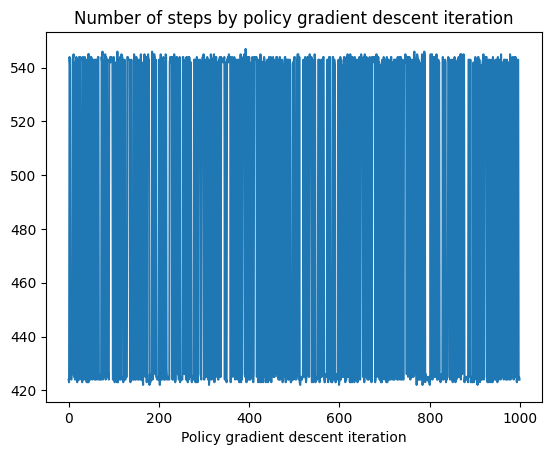

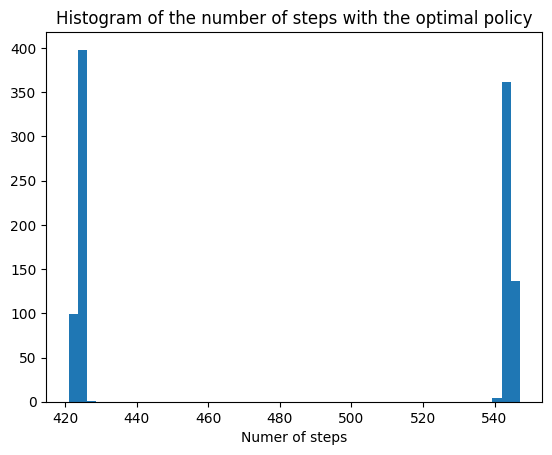

In [33]:
# Get the average number of steps with this policy
N = 1000
T = 1000
steps = T*np.ones(N)
for i in range(N):
    s_t = generate_episode(T,get_policy2(w),next_state_wind)
    
    for t in range(T):
        if abs(s_t[t][0] - 1) < 1e-2 or s_t[t][0] >= 1:
            steps[i] = t
            break

plt.figure()
plt.plot(range(len(R_i)),np.log(R_i)/np.log(0.99))
plt.xlabel('Policy gradient descent iteration')
plt.title('Number of steps by policy gradient descent iteration')

plt.figure()
plt.hist(steps,bins=50)
plt.xlabel('Numer of steps')
plt.title('Histogram of the number of steps with the optimal policy')

print('Policy gradient descent output : {}'.format(w))
print('Mean number of steps : {}, Success rate {}'.format(np.mean(steps[steps<T]),np.sum(steps<T)/N)) 

In windy conditions, the mean number of steps with this policy is $484.4$, which is very near to the initial conditions ($485.2$ steps in average without wind). This is not surprising neither, since the wind has zero expectancy.

Though, we observe that the two peaks are a bit more spread out and less pronounced. Indeed, the introduction of wind ads variability in the environment. The randomness of the $e_k$ at each state results in a wider range of possible outcomes.